In [1]:
# GPLVM training
from mesh_to_sdf import mesh_to_voxels
import trimesh
import numpy as np

obj_names = ['Jeep', 'Pickup', 'Sedan', 'Suv']
voxel_resolution = 64
dct_resolution = 25

def generateAndSaveSdf(obj_name, voxel_resolution):
    mesh = trimesh.load(f'objs3/{obj_name}.obj')
    print(f'Generating {voxel_resolution}x{voxel_resolution}x{voxel_resolution} SDF for {obj_name}...')
    voxels = mesh_to_voxels(mesh, voxel_resolution)
    voxels = np.array(voxels)
    np.save(f'objs3/{obj_name}_SDF_{voxel_resolution}x{voxel_resolution}x{voxel_resolution}', voxels)
    print(f'SDF for {obj_name} generated and saved.')
    return voxels


In [4]:
# # Generate (if not generated yet)
# for obj_name in obj_names:
#     generateAndSaveSdf(obj_name, voxel_resolution)

Generating 64x64x64 SDF for Jeep...
SDF for Jeep generated and saved.
Generating 64x64x64 SDF for Pickup...
SDF for Pickup generated and saved.
Generating 64x64x64 SDF for Sedan...
SDF for Sedan generated and saved.
Generating 64x64x64 SDF for Suv...
SDF for Suv generated and saved.


In [2]:
# Load from generated & saved SDF
sdfs = []
for obj_name in obj_names:
    sdfs.append(np.load(f'objs3/{obj_name}_SDF_{voxel_resolution}x{voxel_resolution}x{voxel_resolution}.npy'))
sdfs = np.array(sdfs)
sdfs.shape

(4, 64, 64, 64)

In [3]:
# 3D DCT
# 3D DCT function
import numpy as np
from scipy.fftpack import dct, idct

def dctn(x, norm="ortho"):
    for i in range(x.ndim):
        x = dct(x, axis=i, norm=norm)
    return x

def idctn(x, norm="ortho"):
    for i in range(x.ndim):
        x = idct(x, axis=i, norm=norm)
    return x

# 3D DCT the voxels
dct_trimmeds = []
for sdf in sdfs:
    dct_full = dctn(sdf)
    dct_trimmeds.append(dct_full[:dct_resolution, :dct_resolution, :dct_resolution])

In [4]:
# GPLVM Training
from mygplvm.mygplvm import MyGPLVM

gplvm = MyGPLVM()
dct_flatteneds = []
for dct_trimmed in dct_trimmeds:
    dct_flatteneds.append(dct_trimmed.flatten())
gplvm.simple_gplvm(dct_flatteneds, 'vehicle_models', latent_dimension = 2, epsilon = 0.001, maxiter = 50)

         Current function value: 74057.302579
         Iterations: 3
         Function evaluations: 600
         Gradient evaluations: 49
time: 0.14207124710083008
alpha 1.1739144324255208
beta 0.6012194508290427
gamma 0.9999424891568225


c:\ProgramData\anaconda3\envs\python310\lib\site-packages\scipy\optimize\_optimize.py:1698: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, **opts)


array([[-28.79346657,  15.8886137 ],
       [ 40.5033989 ,   7.74951506],
       [ -7.06363386, -13.97270064],
       [ -4.64631563,  -9.66540283]])

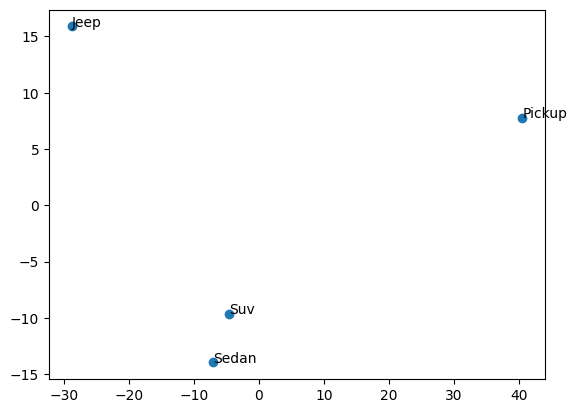

In [5]:
import matplotlib.pyplot as plt

# Scatter plot latent variable
fig, ax = plt.subplots()
ax.scatter(gplvm.X[:, 0], gplvm.X[:, 1])

for i, txt in enumerate(obj_names):
    ax.annotate(txt, (gplvm.X[i, 0], gplvm.X[i, 1]))

In [6]:
import skimage

dct_25_flat = gplvm.recall([ -4.64631992,  -9.66540187])
dct_25 = np.array(dct_25_flat).reshape((dct_resolution, dct_resolution, dct_resolution))
dct_full = np.pad(dct_25, ((0, voxel_resolution - dct_resolution + 2), (0, voxel_resolution - dct_resolution + 2), (0, voxel_resolution - dct_resolution + 2)))
print(dct_full.shape)

voxels_idct = idctn(dct_full)
voxels_idct = np.pad(voxels_idct, ((1, 1), (1, 1), (1, 1)), constant_values=(1, 1))
mc_vertices, mc_faces, mc_normals, _ = skimage.measure.marching_cubes(voxels_idct, level=0)
mc_mesh = trimesh.Trimesh(vertices=mc_vertices, faces=mc_faces, normals=mc_normals)
mc_mesh.apply_translation([-((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2)])
mc_mesh.show()

(66, 66, 66)


## Image Segmentation

In [55]:
from ultralytics import YOLO
import torch

device_name = 'cpu'
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device_name = '0'
    yolov9 = YOLO("yolov9c-seg.pt").to('cuda')
    print('Detecting using GPU...')
else:
    device_name = 'cpu'
    yolov9 = YOLO("yolov9c-seg.pt").to('cpu')
    print('Detecting using CPU...')

Detecting using GPU...


In [68]:
import cv2
import numpy as np

segmented = yolov9.predict('images/input3_cropped1.png')

maximum_idx = None
maximum_area = None
for i, box in enumerate(segmented[0].boxes):
    if maximum_idx == None or box.xywh[0][2] * box.xywh[0][3] > maximum_area:
        maximum_idx = i
        maximum_area = box.xywh[0][2] * box.xywh[0][3]

maximum_mask = segmented[0].masks[maximum_idx].data[0].cpu().numpy().astype(np.uint8) * 255
cv2.imwrite('segmented_img.jpg', maximum_mask)
maximum_polygon = segmented[0].masks[maximum_idx]


image 1/1 c:\Bryan\TA\Integrated\images\input3_cropped1.png: 448x640 1 car, 243.9ms
Speed: 293.8ms preprocess, 243.9ms inference, 4.5ms postprocess per image at shape (1, 3, 448, 640)


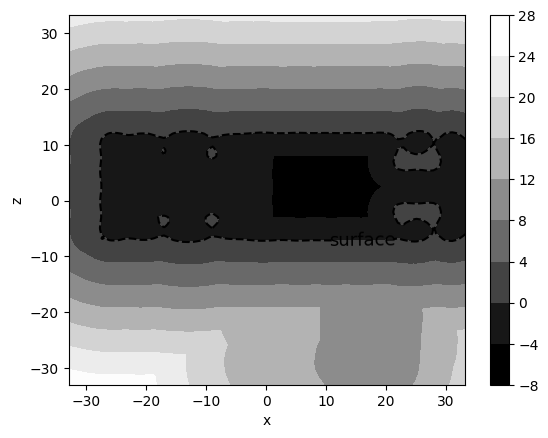

In [28]:
import pytorch_volumetric as pv
import pytorch_kinematics as pk
import torch
from mygplvm.myoptimization2 import MyOptimization2

mo2 = MyOptimization2()
sdf = mo2.reconstruct(gplvm, [     40.503,      7.7495], dct_resolution, voxel_resolution)
# tsf = pk.RotateAxisAngle(90, axis='x')
# tsf = pk.Translate(x = 0, y = 0, z = 0)
# tsf = pk.Scale()
tsf = pk.Transform3d(matrix=torch.asarray([
    [1.0, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
]))
sdf = pv.ComposedSDF([sdf, sdf], tsf.stack(tsf))

query_range = np.array([
            [-33, 33],
            [0, 0],
            [-33, 33],
        ])
result = pv.draw_sdf_slice(sdf, query_range, resolution=80/256)

In [66]:
from mygplvm.myoptimization3 import MyOptimization3
import pyrender
import numpy as np
import trimesh
import cv2
import math
from math import sin, cos

mo3 = MyOptimization3()
mc_mesh = mo3.reconstruct(gplvm, [-6.646315625715095, -8.665402827584778], dct_resolution, voxel_resolution)
mc_mesh.apply_transform([
    [cos(math.radians(0))  , 0, sin(math.radians(-0))  , 0],
    [0                      , 1, 0                      , 0],
    [-sin(math.radians(0)) , 0, cos(math.radians(0))  , 0],
    [0                      , 0, 0                      , 1]
])
bbox = np.max(np.abs(np.array(trimesh.bounds.corners(mc_mesh.bounding_box.bounds))), axis=0)
bbox_bound = max(bbox[0], bbox[1])

r = pyrender.OffscreenRenderer(256, 256)
scene = pyrender.Scene(ambient_light=[0.6, 0.6, 0.6], bg_color=[1.0, 1.0, 1.0])

mesh_pyrender = pyrender.Mesh.from_trimesh(mc_mesh, smooth=False)
camera_pose = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 64],
            [0, 0, 0, 1]
        ])
light_pose = np.array([
    [1, 0, 0, 62],
    [0, 1, 0, 62],
    [0, 0, 1, 62],
    [0, 0, 0, 1]
])
pl = pyrender.PointLight(color=[1.0, 1.0, 1.0], intensity=50000)
pc = pyrender.OrthographicCamera(bbox_bound, bbox_bound)
#pc = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1280/720)
scene.add(mesh_pyrender, pose=np.eye(4))
scene.add(pl, pose=light_pose)
scene.add(pc, pose=camera_pose)
color, _ = r.render(scene)
cv2.imwrite('rendered.png', color)

r.delete()


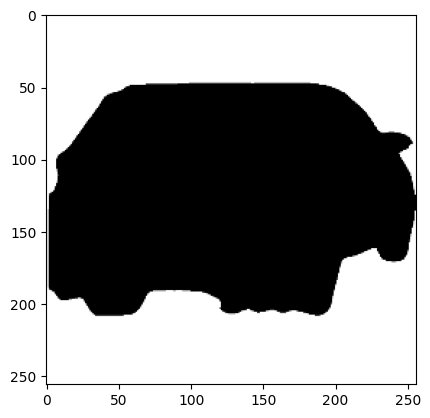

In [69]:
img = cv2.imread('segmented_img.jpg', cv2.IMREAD_GRAYSCALE)
def make_square(im, desired_size = 256):
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    resized = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return resized

resized =  make_square(img)
plt.imshow(resized, cmap='binary')

In [70]:
from mygplvm.myoptimization3 import MyOptimization3
import pyrender
import numpy as np
import trimesh
import cv2
import math
from math import sin, cos

r = pyrender.OffscreenRenderer(256, 256)
camera_pose = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 64],
    [0, 0, 0, 1]
])
light_pose = np.array([
    [1, 0, 0, 62],
    [0, 1, 0, 62],
    [0, 0, 1, 62],
    [0, 0, 0, 1]
])
pl = pyrender.PointLight(color=[1.0, 1.0, 1.0], intensity=50000)
pc = pyrender.OrthographicCamera(bbox_bound, bbox_bound)

mo3 = MyOptimization3()
latent_variables = []
energies = []
for x0 in gplvm.X:
    for dx1 in range(-2, 3):
        for dx2 in range(-2, 3):
            x = [x0[0] + dx1, x0[1] + dx2]
            mc_mesh = mo3.reconstruct(gplvm, x, dct_resolution, voxel_resolution)
            mc_mesh.apply_transform([
                [cos(math.radians(-15))  , 0, sin(math.radians(-15))  , 0],
                [0                      , 1, 0                      , 0],
                [-sin(math.radians(-15)) , 0, cos(math.radians(-15))  , 0],
                [0                      , 0, 0                      , 1]
            ])
            bbox = np.max(np.abs(np.array(trimesh.bounds.corners(mc_mesh.bounding_box.bounds))), axis=0)
            bbox_bound = max(bbox[0], bbox[1])

            scene = pyrender.Scene(ambient_light=[0.6, 0.6, 0.6], bg_color=[1.0, 1.0, 1.0])
            mesh_pyrender = pyrender.Mesh.from_trimesh(mc_mesh, smooth=False)
            #pc = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1280/720)
            scene.add(mesh_pyrender, pose=np.eye(4))
            scene.add(pl, pose=light_pose)
            scene.add(pc, pose=camera_pose)
            color, _ = r.render(scene)
            
            rendered_occupancy = np.any(color != 255, axis=2)
            
            energy = np.sum(resized * rendered_occupancy + (255 - resized) * (1 - rendered_occupancy))
            energies.append(energy)
            latent_variables.append(x)
            # energies.append({ 'x': x, 'energy': energy})

r.delete()

In [71]:
print(energies.index(max(energies)), max(energies))

69 13560176


In [72]:
latent_variables[69]

[-6.063633861852665, -11.972700636357004]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
calculating epoch 1...
lambdas: [tensor(0.0140), tensor(22.2648), tensor(-4.1286), tensor(0.0556), tensor(-5.2314), tensor(-0.7975), tensor(1.0022)]


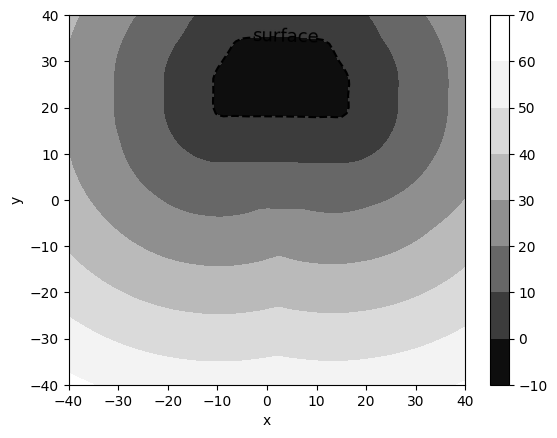

calculating epoch 2...


KeyboardInterrupt: 

In [17]:
from PIL import Image, ImageOps
import cv2
import math
from math import sin, cos
import numpy as np
import pytorch_volumetric as pv
import pytorch_kinematics as pk
import torch


def make_square(img):
        resized = cv2.resize(img, (64, 64))
        return resized
        

def reconstruct(gplvm, latent_init, dct_resolution, voxel_resolution, num_iter = 10):
        dct_25_flat = gplvm.recall(latent_init)
        dct_25 = np.array(dct_25_flat).reshape((dct_resolution, dct_resolution, dct_resolution))
        dct_full = np.pad(dct_25, ((0, voxel_resolution - dct_resolution), (0, voxel_resolution - dct_resolution), (0, voxel_resolution - dct_resolution)))
        voxels_idct = idctn(dct_full)
        voxels_idct = np.pad(voxels_idct, ((1, 1), (1, 1), (1, 1)), constant_values=(1, 1))
        
        mc_vertices, mc_faces, mc_normals, _ = skimage.measure.marching_cubes(voxels_idct, level=0)
        mc_mesh = trimesh.Trimesh(vertices=mc_vertices, faces=mc_faces, normals=mc_normals)
        mc_mesh.apply_translation([-((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2)])
        mc_mesh.apply_transform([
            [cos(math.radians(90))  , 0, sin(math.radians(90))  , 0],
            [0                      , 1, 0                      , 0],
            [-sin(math.radians(90)) , 0, cos(math.radians(90))  , 0],
            [0                      , 0, 0                      , 1]
        ])

        # convert to open3d
        o3d_mesh = mc_mesh.as_open3d

        # convert to sdf
        obj = pv.MeshObjectFactory(mesh=o3d_mesh)
        sdf0 = pv.MeshSDF(obj)
        tsf = pk.Transform3d(matrix=torch.asarray([
            [1.0, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ]))
        sdf = pv.ComposedSDF([sdf0, sdf0], tsf.stack(tsf))

        ## energy function derivative calculation
        # parameters initialization
        image_resolution = 64
        learning_rate = 1
        zeta_smoothing = 3
        fu = 512
        fv = 512
        lambdas = [0. for i in range(7)]    # Tx, Ty, Tz, Rx, Ry, Rz, S; all rotation in degree
        li_mapping = {
             'Tx': 0,
             'Ty': 1,
             'Tz': 2,
             'Rx': 3,
             'Ry': 4,
             'Rz': 5,
             'S': 6
        }
        lambdas[li_mapping['S']] = 1    # set scale to 1

        # epochs
        for n in range(num_iter):
            print(f'calculating epoch {n+1}...')
            dE_dlis = [0 for i in range(len(lambdas))]

            Tx = lambdas[li_mapping['Tx']]
            Ty = lambdas[li_mapping['Ty']]
            Tz = lambdas[li_mapping['Tz']]
            Rx = math.radians(lambdas[li_mapping['Rx']])
            Ry = math.radians(lambdas[li_mapping['Ry']])
            Rz = math.radians(lambdas[li_mapping['Rz']])
            S = lambdas[li_mapping['S']]

            M = np.matrix([
                [S*cos(Ry)*cos(Rz)                              , -S*cos(Ry)*sin(Rz)                            , S*sin(Ry)         , Tx],
                [S*cos(Rx)*sin(Rz) + S*sin(Rx)*sin(Ry)*cos(Rz)  , S*cos(Rx)*cos(Rz) - S*sin(Rx)*sin(Ry)*sin(Rz) , -S*sin(Rx)*cos(Ry), Ty],
                [S*sin(Rx)*sin(Rz) - S*cos(Rx)*sin(Ry)*cos(Rz)  , S*sin(Rx)*cos(Rz) + S*cos(Rx)*sin(Ry)*sin(Rz) , S*cos(Rx)*cos(Ry) , Tz],
                [0                                              , 0                                             , 0                 , 1]
            ])
            MI = M.I

            # iterate the image
            proj_phi = [[0 for j in range(image_resolution)] for i in range(image_resolution)]
            for u in range(image_resolution):
                # print(f'\tu = {u}')
                query_range = np.array([
                    [-40, 40],
                    [40 - (80/image_resolution) * u, 40 - (80/image_resolution) * u],
                    [-40, 40],
                ])
                coords, pts = pv.get_coordinates_and_points_in_grid(80 / image_resolution, query_range)
                sdf_val, sdf_grad = sdf(pts)
                for v in range(image_resolution):
                    rf_min_rb = 2 * input_image[u][v] - 1
                    # for i in range(len(lambdas)):
                    # lambda_i = lambdas[i]

                    sigma_lray_dlis = [0 for i in range(len(lambdas))]
                    x = (u - image_resolution//2) / image_resolution
                    y = (image_resolution//2 - v) / image_resolution
                    sigma_log_phi_l = 0
                    for l in range(image_resolution):
                        z = (l - image_resolution//2) / image_resolution
                        [x0, y0, z0, w] = np.array(MI * np.matrix([x, y, z, 1]).T).flatten()

                        phi_l = sdf_val[v + l * (image_resolution + 1)]
                        exp_phi_l_zeta = math.exp(-phi_l * zeta_smoothing)
                        sigma_log_phi_l += math.log(1 - (exp_phi_l_zeta)/(exp_phi_l_zeta + 1))

                        dl_dx = sdf_grad[v + l * (image_resolution + 1)][0]
                        dl_dy = sdf_grad[v + l * (image_resolution + 1)][1]
                        dl_dz = sdf_grad[v + l * (image_resolution + 1)][2]

                        # dx/dli, dy/dli, and dz/dli
                        dx_dlis = [
                                1,
                                0,
                                0,
                                0,
                                -x0*S*sin(Ry)*cos(Rz) + y0*S*sin(Ry)*sin(Rz) + z0*S*cos(Ry),
                                -x0*S*cos(Ry)*sin(Rz) - y0*S*cos(Ry)*cos(Rz),
                                x0*cos(Ry)*cos(Rz) - y0*cos(Ry)*sin(Rz) + z0*sin(Ry)
                        ]
                        dy_dlis = [
                                0,
                                1,
                                0,
                                x0*S*(-sin(Rx)*sin(Rz) + cos(Rx)*sin(Ry)*cos(Rz)) + y0*S*(-sin(Rx)*cos(Rz) - cos(Rx)*sin(Ry)*sin(Rz)) - z0*S*cos(Rx)*cos(Ry),
                                x0*S*(sin(Rx)*cos(Ry)*cos(Rz)) + y0*S*(-sin(Rx)*cos(Ry)*sin(Rz)) + z0*S*cos(Rx)*sin(Ry),
                                x0*S*(cos(Rx)*cos(Rz) - sin(Rx)*sin(Ry)*sin(Rz)) + y0*S*(-cos(Rx)*sin(Rz) - sin(Rx)*sin(Ry)*cos(Rz)),
                                x0*(cos(Rx)*sin(Rz) + sin(Rx)*sin(Ry)*sin(Rz)) + y0*(cos(Rx)*cos(Rz) - sin(Rx)*sin(Ry)*sin(Rz)) - z0*sin(Rx)*cos(Ry)
                        ]
                        dz_dlis = [
                                0,
                                0,
                                1,
                                x0*S*(cos(Rx)*sin(Rz) + sin(Rx)*sin(Ry)*cos(Rz)) + y0*S*(cos(Rx)*cos(Rz) - sin(Rx)*sin(Ry)*sin(Rz)) + z0*S*(-sin(Rx)*cos(Ry)),
                                x0*S*(-cos(Rx)*cos(Ry)*cos(Rz)) + y0*S*(cos(Rx)*cos(Ry)*sin(Rz)) + z0*S*(-cos(Rx)*sin(Ry)),
                                x0*S*(sin(Rx)*cos(Rz) + cos(Rx)*sin(Ry)*sin(Rz)) + y0*S*(-sin(Rx)*sin(Rz) + cos(Rx)*sin(Ry)*cos(Rz)),
                                x0*(sin(Rx)*sin(Rz) - cos(Rx)*sin(Ry)*cos(Rz)) + y0*(sin(Rx)*cos(Rz) + cos(Rx)*sin(Ry)*sin(Rz)) + z0*(cos(Rx)*cos(Ry))
                        ]
                        
                        dl_dlis = [dl_dx * dx_dlis[i] + dl_dy * dy_dlis[i] + dl_dz * dz_dlis[i] for i in range(len(lambdas))]
                        for i in range(len(dl_dlis)):
                            sigma_lray_dlis[i] += (exp_phi_l_zeta / (exp_phi_l_zeta + 1)) * dl_dlis[i]

                    
                    for i in range(len(dE_dlis)):
                        dE_dlis[i] += -rf_min_rb * math.exp(sigma_log_phi_l) * sigma_lray_dlis[i]
            #         proj_phi[u][v] = 1 - math.exp(sigma_log_phi_l)
            
            # plt.imshow(proj_phi, cmap='gray')
            # return
            # energy gradient calculation finished
            li_stepsizes = [1, 1, 1, 1, 30, 1, 0.001]
            for i in range(len(lambdas)):
                lambdas[i] = lambdas[i] + li_stepsizes[i] * dE_dlis[i] * 1

            print('lambdas:', lambdas)

            Tx = -lambdas[li_mapping['Tx']]
            Ty = -lambdas[li_mapping['Ty']]
            Tz = -lambdas[li_mapping['Tz']]
            Rx = -math.radians(lambdas[li_mapping['Rx']])
            Ry = -math.radians(lambdas[li_mapping['Ry']])
            Rz = -math.radians(lambdas[li_mapping['Rz']])
            S = 1/lambdas[li_mapping['S']]
            M = np.matrix([
                [S*cos(Ry)*cos(Rz)                              , -S*cos(Ry)*sin(Rz)                            , S*sin(Ry)         , Tx],
                [S*cos(Rx)*sin(Rz) + S*sin(Rx)*sin(Ry)*cos(Rz)  , S*cos(Rx)*cos(Rz) - S*sin(Rx)*sin(Ry)*sin(Rz) , -S*sin(Rx)*cos(Ry), Ty],
                [S*sin(Rx)*sin(Rz) - S*cos(Rx)*sin(Ry)*cos(Rz)  , S*sin(Rx)*cos(Rz) + S*cos(Rx)*sin(Ry)*sin(Rz) , S*cos(Rx)*cos(Ry) , Tz],
                [0                                              , 0                                             , 0                 , 1.0]
            ])
            MI = M.I

            tsf = pk.Transform3d(matrix=torch.asarray(M.tolist()))
            sdf = pv.ComposedSDF([sdf0, sdf0], tsf.stack(tsf))
            query_range = np.array([
                        [-40, 40],
                        [-40, 40],
                        [0, 0],
                    ])
            result = pv.draw_sdf_slice(sdf, query_range, resolution=80/image_resolution)
        
        return lambdas


        
input_image = cv2.imread('input_images/sedan1.png', cv2.IMREAD_GRAYSCALE)
input_image = make_square(input_image)
input_image = (255 - input_image) / 255
# plt.imshow(input_image, cmap='gray')

lambdas = reconstruct(gplvm, [-13.68171972, -10.0678005 ], dct_resolution, voxel_resolution, num_iter=15)

In [47]:
from PIL import Image, ImageOps
import cv2
import skimage
import math
from math import sin, cos
import numpy as np
import pytorch_volumetric as pv
import pytorch_kinematics as pk
import torch


def make_square(img):
    resized = cv2.resize(img, (64, 64))
    return resized

calculating epoch 1...
lambdas: [0.0, 0.0, 0.0, -4.998332589151172, -0.109033781351748, -2.67513326231681, 1.0]


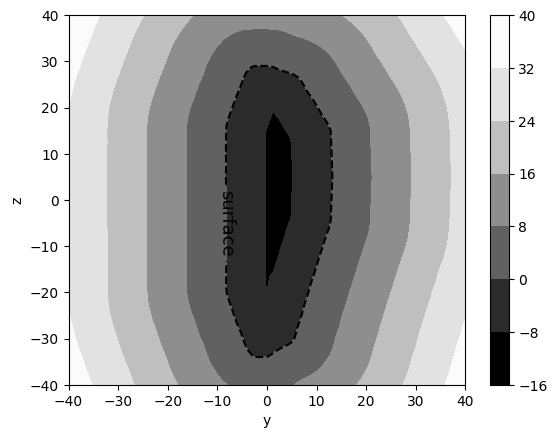

calculating epoch 2...


KeyboardInterrupt: 

In [67]:
import cupy

file = open('../reconstruct_gpu.cu', 'r')
optimize_pose_code = file.read()
optimize_pose = cupy.RawKernel(optimize_pose_code, 'optimize_pose')
file.close()

def reconstruct_gpu(gplvm, latent_init, dct_resolution, voxel_resolution, num_iter = 10):
    dct_25_flat = gplvm.recall(latent_init)
    dct_25 = np.array(dct_25_flat).reshape((dct_resolution, dct_resolution, dct_resolution))
    dct_full = np.pad(dct_25, ((0, voxel_resolution - dct_resolution), (0, voxel_resolution - dct_resolution), (0, voxel_resolution - dct_resolution)))
    voxels_idct = idctn(dct_full)
    voxels_idct = np.pad(voxels_idct, ((1, 1), (1, 1), (1, 1)), constant_values=(1, 1))
    
    mc_vertices, mc_faces, mc_normals, _ = skimage.measure.marching_cubes(voxels_idct, level=0)
    mc_mesh = trimesh.Trimesh(vertices=mc_vertices, faces=mc_faces, normals=mc_normals)
    mc_mesh.apply_translation([-((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2)])
    mc_mesh.apply_transform([
        [cos(math.radians(90))  , 0, sin(math.radians(90))  , 0],
        [0                      , 1, 0                      , 0],
        [-sin(math.radians(90)) , 0, cos(math.radians(90))  , 0],
        [0                      , 0, 0                      , 1]
    ])

    # convert to open3d
    o3d_mesh = mc_mesh.as_open3d

    # convert to sdf
    obj = pv.MeshObjectFactory(mesh=o3d_mesh)
    sdf0 = pv.MeshSDF(obj)
    tsf = pk.Transform3d(matrix=torch.asarray([
        [1.0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ]))
    sdf = pv.ComposedSDF([sdf0, sdf0], tsf.stack(tsf))

    ## energy function derivative calculation
    # parameters initialization
    image_resolution = 64
    lambdas = [0. for i in range(7)]    # Tx, Ty, Tz, Rx, Ry, Rz, S; all rotation in degree
    li_mapping = {
            'Tx': 0,
            'Ty': 1,
            'Tz': 2,
            'Rx': 3,
            'Ry': 4,
            'Rz': 5,
            'S': 6
    }
    lambdas[li_mapping['S']] = 1    # set scale to 1

    # epochs
    for n in range(num_iter):
        print(f'calculating epoch {n+1}...')
        dE_dlis = cupy.asarray([0 for i in range(len(lambdas * image_resolution * image_resolution))], dtype=cupy.float32)

        Tx = lambdas[li_mapping['Tx']]
        Ty = lambdas[li_mapping['Ty']]
        Tz = lambdas[li_mapping['Tz']]
        Rx = math.radians(lambdas[li_mapping['Rx']])
        Ry = math.radians(lambdas[li_mapping['Ry']])
        Rz = math.radians(lambdas[li_mapping['Rz']])
        S = lambdas[li_mapping['S']]

        M = np.matrix([
            [S*cos(Ry)*cos(Rz)                              , -S*cos(Ry)*sin(Rz)                            , S*sin(Ry)         , Tx],
            [S*cos(Rx)*sin(Rz) + S*sin(Rx)*sin(Ry)*cos(Rz)  , S*cos(Rx)*cos(Rz) - S*sin(Rx)*sin(Ry)*sin(Rz) , -S*sin(Rx)*cos(Ry), Ty],
            [S*sin(Rx)*sin(Rz) - S*cos(Rx)*sin(Ry)*cos(Rz)  , S*sin(Rx)*cos(Rz) + S*cos(Rx)*sin(Ry)*sin(Rz) , S*cos(Rx)*cos(Ry) , Tz],
            [0                                              , 0                                             , 0                 , 1]
        ])
        MI = cupy.asarray(M.I, dtype=cupy.float32)

        sdfs = np.zeros((image_resolution, image_resolution, image_resolution))
        grads = np.zeros((image_resolution, image_resolution, image_resolution, 3))
        for i in range(image_resolution):
            query_range = np.array([
                [-40, 40],
                [40 - (80/image_resolution) * i, 40 - (80/image_resolution) * i],
                [-40, 40],
            ])
            coords, pts = pv.get_coordinates_and_points_in_grid(80 / image_resolution, query_range)
            sdf_val, sdf_grad = sdf(pts)
            for j in range(image_resolution):
                for k in range(image_resolution):
                    sdfs[i,j,k] = sdf_val[j * (image_resolution + 1) + k]
                    for l in range(3):
                        grads[i,j,k,l] = sdf_grad[j * (image_resolution + 1) + k][l]
            
            # Optimize GPU
            # void optimize_pose(const float * input_image, const float * sdfs, const float * grads, const float * lambdas, float * dE_dlis, float MI[4][4], const int dimension)
            threads_per_block = 512
            block_size = (threads_per_block, 1, 1)
            grid_size = (int(math.ceil(image_resolution * image_resolution / threads_per_block)), 1, 1)
            sdfs_cp = cupy.asarray(sdfs.flatten(), dtype=cupy.float32)
            grads_cp = cupy.asarray(grads.flatten(), dtype=cupy.float32)
            optimize_pose(grid_size, block_size, (input_image, sdfs_cp, grads_cp, cupy.asarray(lambdas, dtype=cupy.float32), dE_dlis, MI, image_resolution))
        
        # # project the ray
        # plt.imshow(dE_dlis.get()[:image_resolution*image_resolution].reshape((image_resolution, image_resolution)), cmap='gray')
        # return
        
        # Integrate the result
        dE_dlis_cpu = dE_dlis.get()
        dE_dlis_sum = [0 for i in range(len(lambdas))]
        for i in range(image_resolution * image_resolution):
            for j in range(len(lambdas)):
                dE_dlis_sum[j] += dE_dlis_cpu[i * len(lambdas) + j]

        # Update lambdas
        li_stepsizes = [1, 1, 1, 1, 1, 1, 0.00001]
        for i in range(len(lambdas)):
            lambdas[i] = lambdas[i] + li_stepsizes[i] * dE_dlis_sum[i] * 0.01

        print('lambdas:', lambdas)

        Tx = lambdas[li_mapping['Tx']]
        Ty = lambdas[li_mapping['Ty']]
        Tz = lambdas[li_mapping['Tz']]
        Rx = math.radians(lambdas[li_mapping['Rx']])
        Ry = math.radians(lambdas[li_mapping['Ry']])
        Rz = math.radians(lambdas[li_mapping['Rz']])
        S = lambdas[li_mapping['S']]
        M = np.matrix([
            [S*cos(Ry)*cos(Rz)                              , -S*cos(Ry)*sin(Rz)                            , S*sin(Ry)         , Tx],
            [S*cos(Rx)*sin(Rz) + S*sin(Rx)*sin(Ry)*cos(Rz)  , S*cos(Rx)*cos(Rz) - S*sin(Rx)*sin(Ry)*sin(Rz) , -S*sin(Rx)*cos(Ry), Ty],
            [S*sin(Rx)*sin(Rz) - S*cos(Rx)*sin(Ry)*cos(Rz)  , S*sin(Rx)*cos(Rz) + S*cos(Rx)*sin(Ry)*sin(Rz) , S*cos(Rx)*cos(Ry) , Tz],
            [0                                              , 0                                             , 0                 , 1.0]
        ])
        MI = cupy.asarray(M.I, dtype=cupy.float32)

        tsf = pk.Transform3d(matrix=torch.asarray(M.I.tolist()))
        sdf = pv.ComposedSDF([sdf0, sdf0], tsf.stack(tsf))
        query_range = np.array([
                    [0, 0],
                    [-40, 40],
                    [-40, 40],
                ])
        result = pv.draw_sdf_slice(sdf0, query_range, resolution=80/image_resolution)
    
    return lambdas


        
input_image = cv2.imread('input_images/sedan1.png', cv2.IMREAD_GRAYSCALE)
input_image = make_square(input_image)
input_image = (255 - input_image) / 255
# plt.imshow(input_image, cmap='gray')
input_image = cupy.asarray(np.array(input_image).flatten(), dtype=cupy.float32)

lambdas = reconstruct_gpu(gplvm, [-13.68171972, -10.0678005 ], dct_resolution, voxel_resolution, num_iter=15)
